In [1]:
%matplotlib inline
import os
import argparse
import sys
import subprocess
import random
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
import multiprocessing
import glob
import signal
import pandas as pd
import seaborn as sbn

/home/sparrow/.conda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/sparrow/.conda/envs/py27/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
path = "./statsT.log"

In [3]:
dtypeC={'region':'object','tissue':'object','sample':'int','sf':'float','cov':'float','tpm':'float','chr':'object','start':'int','end':'int','tname':'object'}
data = pd.read_csv(path,sep="\t",skiprows=1,names=['tissue','chr','refID','tID','start','end','sample','sf','cov','tpm'],dtype=dtypeC)

# uniqueFACTORS = pd.unique(data["sf"])
# uniqueREGIONS = pd.unique(data["region"])
# uniqueTISSUES = pd.unique(data["tissue"])
# uniqueSAMPLES = pd.unique(data["sample"])
# uniqueCHROMOS = pd.unique(data["chr"])

# Aggregate a column for uniqueID
# ID column will be used for quantification of results and building the results DF
data["ID"] = data["tissue"]+":"+data["chr"]+":"+data['refID']+":"+data["tID"]+":"+data["start"].astype(str)+"-"+data["end"].astype(str)

# First reject all transcripts for which tpm==0.0 at sf==1.0
dataOff = pd.unique(data[(data["sf"] == 1.0) & (data["tpm"] == 0.0)]["ID"])
uniqueID1Maintain = pd.unique(data[~data["ID"].isin(dataOff)]["ID"])
dataN = data[~data["ID"].isin(uniqueID1Maintain)]
data = data[data["ID"].isin(uniqueID1Maintain)]

data["lost"] = data.apply(lambda row: row["tpm"] == 0.0,axis=1)
# data["lostN"] = data.apply(lambda row: row["sf"] if row["lost"] else 0,axis=1)

In [4]:
# 7 Computes the number of novel mistakes at each coverage point
setNo = set(dataN[(dataN["sf"]==1.0)&(dataN["tpm"]==0.0)]["ID"].unique()) # Lets try counting the number of novel mistake
setYes = set(dataN[(dataN["sf"]==1.0)&(dataN["tpm"]!=0.0)]["ID"].unique()) # Lets try counting the number of novel mistake
setFin = list(setNo.difference(setYes)) # Lets try counting the number of novel mistake
dataT = dataN[dataN['ID'].isin(setFin)]
dataSF = pd.DataFrame(dataT.groupby(['sf']).mean()).reset_index()
dataSF["NovelMistakes"] = dataSF.apply(lambda row: len(dataT[(dataT['ID'].isin(setFin))&(dataT["tpm"]!=0.0)&(dataT["sf"]==row["sf"])]),axis=1)
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes
0,0.1,7.369301e+07,7.378583e+07,1.004069,0.016496,0.141096,4138
1,0.2,7.418290e+07,7.427480e+07,1.000063,0.019092,0.081267,3335
2,0.3,7.390394e+07,7.399532e+07,1.000056,0.017949,0.050817,2668
3,0.4,7.353515e+07,7.362661e+07,0.998986,0.017694,0.037581,2168
4,0.5,7.371522e+07,7.380644e+07,0.999279,0.015460,0.026280,1700
5,0.6,7.339853e+07,7.348973e+07,1.001562,0.015630,0.022179,1436
6,0.7,7.364074e+07,7.373172e+07,1.000207,0.011973,0.014583,1061
7,0.8,7.360308e+07,7.369394e+07,1.000013,0.009341,0.009966,768
8,0.9,7.350186e+07,7.359275e+07,0.999741,0.005826,0.005532,463
9,1.0,7.351851e+07,7.360928e+07,1.000000,0.000000,0.000000,0


In [5]:
# 2 Here we shall also count the number of losses
dataSF["NumLostIndivSamples"] = dataSF.apply(lambda row: len(data[(data["sf"] == row["sf"])&(data["lost"])]),axis=1)
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples
0,0.1,7.369301e+07,7.378583e+07,1.004069,0.016496,0.141096,4138,24763
1,0.2,7.418290e+07,7.427480e+07,1.000063,0.019092,0.081267,3335,17033
2,0.3,7.390394e+07,7.399532e+07,1.000056,0.017949,0.050817,2668,12677
3,0.4,7.353515e+07,7.362661e+07,0.998986,0.017694,0.037581,2168,9727
4,0.5,7.371522e+07,7.380644e+07,0.999279,0.015460,0.026280,1700,7409
5,0.6,7.339853e+07,7.348973e+07,1.001562,0.015630,0.022179,1436,5678
6,0.7,7.364074e+07,7.373172e+07,1.000207,0.011973,0.014583,1061,4172
7,0.8,7.360308e+07,7.369394e+07,1.000013,0.009341,0.009966,768,2809
8,0.9,7.350186e+07,7.359275e+07,0.999741,0.005826,0.005532,463,1457
9,1.0,7.351851e+07,7.360928e+07,1.000000,0.000000,0.000000,0,0


In [6]:
# 2 here we shall add information about total losses
dataLostAll = pd.DataFrame(data.groupby(["ID","sf"]).mean()).reset_index()
dataSF["NumLostAllSamples"] = dataSF.apply(lambda row: len(dataLostAll[(dataLostAll["sf"] == row["sf"])&(dataLostAll["lost"] == 1.0)]),axis=1)
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples
0,0.1,7.369301e+07,7.378583e+07,1.004069,0.016496,0.141096,4138,24763,5058
1,0.2,7.418290e+07,7.427480e+07,1.000063,0.019092,0.081267,3335,17033,2942
2,0.3,7.390394e+07,7.399532e+07,1.000056,0.017949,0.050817,2668,12677,1949
3,0.4,7.353515e+07,7.362661e+07,0.998986,0.017694,0.037581,2168,9727,1218
4,0.5,7.371522e+07,7.380644e+07,0.999279,0.015460,0.026280,1700,7409,799
5,0.6,7.339853e+07,7.348973e+07,1.001562,0.015630,0.022179,1436,5678,479
6,0.7,7.364074e+07,7.373172e+07,1.000207,0.011973,0.014583,1061,4172,253
7,0.8,7.360308e+07,7.369394e+07,1.000013,0.009341,0.009966,768,2809,135
8,0.9,7.350186e+07,7.359275e+07,0.999741,0.005826,0.005532,463,1457,58
9,1.0,7.351851e+07,7.360928e+07,1.000000,0.000000,0.000000,0,0,0


In [7]:
# 3 Calculating the total number of transcripts at a particular coverage point
dataSF["NumTranscripts"] = pd.DataFrame(data.groupby(["sf"],as_index=False)["tpm"].count())["tpm"]
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples,NumTranscripts
0,0.1,7.369301e+07,7.378583e+07,1.004069,0.016496,0.141096,4138,24763,5058,80256
1,0.2,7.418290e+07,7.427480e+07,1.000063,0.019092,0.081267,3335,17033,2942,81532
2,0.3,7.390394e+07,7.399532e+07,1.000056,0.017949,0.050817,2668,12677,1949,82065
3,0.4,7.353515e+07,7.362661e+07,0.998986,0.017694,0.037581,2168,9727,1218,82362
4,0.5,7.371522e+07,7.380644e+07,0.999279,0.015460,0.026280,1700,7409,799,82545
5,0.6,7.339853e+07,7.348973e+07,1.001562,0.015630,0.022179,1436,5678,479,82673
6,0.7,7.364074e+07,7.373172e+07,1.000207,0.011973,0.014583,1061,4172,253,82792
7,0.8,7.360308e+07,7.369394e+07,1.000013,0.009341,0.009966,768,2809,135,82888
8,0.9,7.350186e+07,7.359275e+07,0.999741,0.005826,0.005532,463,1457,58,82930
9,1.0,7.351851e+07,7.360928e+07,1.000000,0.000000,0.000000,0,0,0,82989


In [8]:
# In the cells below we shall add information about quartiles,mean,cv and extreme outliers and outlier classification

# First we need to express tpm as percentage deviation from the baseTPM
# data["percentAway"] = data.apply(lambda row: row["tpm"]/data[(data["ID"] == row['ID'])&(data["sf"] == 1.0)]["tpm"],axis=1)
dictBase = pd.Series(data[data["sf"]==1.0].tpm.values,index=data[data["sf"]==1.0].ID).to_dict()
data["percentAway"] = data.apply(lambda row: (row["tpm"]/dictBase[row["ID"]])*100 if row["ID"] in dictBase else np.nan,axis=1)


In [9]:
dataSF["q25"] = pd.DataFrame(data.groupby(["sf"])["percentAway"].quantile(0.25)).reset_index()["percentAway"]
dataSF["median"] = pd.DataFrame(data.groupby(["sf"])["percentAway"].quantile(0.50)).reset_index()["percentAway"]
dataSF["q75"] = pd.DataFrame(data.groupby(["sf"])["percentAway"].quantile(0.75)).reset_index()["percentAway"]
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples,NumTranscripts,q25,median,q75
0,0.1,7.369301e+07,7.378583e+07,1.004069,0.016496,0.141096,4138,24763,5058,80256,0.000000,87.008655,123.427237
1,0.2,7.418290e+07,7.427480e+07,1.000063,0.019092,0.081267,3335,17033,2942,81532,45.862565,95.846130,121.134127
2,0.3,7.390394e+07,7.399532e+07,1.000056,0.017949,0.050817,2668,12677,1949,82065,72.572081,98.122312,117.770390
3,0.4,7.353515e+07,7.362661e+07,0.998986,0.017694,0.037581,2168,9727,1218,82362,82.761162,99.080005,114.967367
4,0.5,7.371522e+07,7.380644e+07,0.999279,0.015460,0.026280,1700,7409,799,82545,88.000890,99.374291,112.351839
5,0.6,7.339853e+07,7.348973e+07,1.001562,0.015630,0.022179,1436,5678,479,82673,91.135495,99.773385,110.588113
6,0.7,7.364074e+07,7.373172e+07,1.000207,0.011973,0.014583,1061,4172,253,82792,93.486825,100.003849,108.664513
7,0.8,7.360308e+07,7.369394e+07,1.000013,0.009341,0.009966,768,2809,135,82888,95.564398,100.204971,106.712116
8,0.9,7.350186e+07,7.359275e+07,0.999741,0.005826,0.005532,463,1457,58,82930,97.534829,100.357929,104.569804
9,1.0,7.351851e+07,7.360928e+07,1.000000,0.000000,0.000000,0,0,0,82989,100.000000,100.000000,100.000000


In [10]:
# get average tpm
dataSF["mean"] = pd.DataFrame(data.groupby(["sf"])["percentAway"].mean()).reset_index()["percentAway"]
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples,NumTranscripts,q25,median,q75,mean
0,0.1,7.369301e+07,7.378583e+07,1.004069,0.016496,0.141096,4138,24763,5058,80256,0.000000,87.008655,123.427237,56797.082866
1,0.2,7.418290e+07,7.427480e+07,1.000063,0.019092,0.081267,3335,17033,2942,81532,45.862565,95.846130,121.134127,17468.498067
2,0.3,7.390394e+07,7.399532e+07,1.000056,0.017949,0.050817,2668,12677,1949,82065,72.572081,98.122312,117.770390,24264.231062
3,0.4,7.353515e+07,7.362661e+07,0.998986,0.017694,0.037581,2168,9727,1218,82362,82.761162,99.080005,114.967367,7273.494940
4,0.5,7.371522e+07,7.380644e+07,0.999279,0.015460,0.026280,1700,7409,799,82545,88.000890,99.374291,112.351839,7331.714967
5,0.6,7.339853e+07,7.348973e+07,1.001562,0.015630,0.022179,1436,5678,479,82673,91.135495,99.773385,110.588113,1496.958592
6,0.7,7.364074e+07,7.373172e+07,1.000207,0.011973,0.014583,1061,4172,253,82792,93.486825,100.003849,108.664513,763.452545
7,0.8,7.360308e+07,7.369394e+07,1.000013,0.009341,0.009966,768,2809,135,82888,95.564398,100.204971,106.712116,716.207532
8,0.9,7.350186e+07,7.359275e+07,0.999741,0.005826,0.005532,463,1457,58,82930,97.534829,100.357929,104.569804,922.713751
9,1.0,7.351851e+07,7.360928e+07,1.000000,0.000000,0.000000,0,0,0,82989,100.000000,100.000000,100.000000,100.000000


In [11]:
data

,tissue,chr,refID,tID,start,end,sample,sf,cov,tpm,ID,lost,percentAway
0,SRR810619,chr1,LOC729737,rna18,134773,140566,0,0.1,0.555854,4.753288,SRR810619 :chr1:LOC729737:rna18:134773-140566,False,116.159004
1,SRR810619,chr1,LOC100288069,rna71,764865,778688,0,0.1,0.698491,5.973024,SRR810619 :chr1:LOC100288069:rna71:764865-778688,False,132.668918
9,SRR810619,chr1,LOC105378580,rna80,803389,810065,0,0.1,0.129163,1.104515,SRR810619 :chr1:LOC105378580:rna80:803389-810065,False,86.321661
10,SRR810619,chr1,LINC00115,rna82,826206,827522,0,0.1,1.028094,8.791567,SRR810619 :chr1:LINC00115:rna82:826206-827522,False,130.162461
31,SRR810619,chr1,LOC100133331,rna58,725759,730351,0,0.1,0.556121,4.755572,SRR810619 :chr1:LOC100133331:rna58:725759-730351,False,97.056828
34,SRR810619,chr1,LOC107984850,rna90,860227,868202,0,0.1,0.146860,1.255848,SRR810619 :chr1:LOC107984850:rna90:860227-868202,False,200.311350
37,SRR810619,chr1,LINC01128,rna83,827591,859446,0,0.1,0.085143,0.728086,SRR810619 :chr1:LINC01128:rna83:827591-859446,False,4.556670
38,SRR810619,chr1,LINC01128,rna84,827591,859446,0,0.1,1.644749,14.064784,SRR810619 :chr1:LINC01128:rna84:827591-859446,False,337.900096
39,SRR810619,chr1,LINC01128,rna88,827798,859446,0,0.1,0.871941,7.456251,SRR810619 :chr1:LINC01128:rna88:827798-859446,False,193.190948
40,SRR810619,chr1,LINC01128,rna87,827591,843604,0,0.1,0.225854,1.931351,SRR810619 :chr1:LINC01128:rna87:827591-843604,False,98.900312


In [12]:
# Here we shall calculate whiskers
def calcWhisk(row):
#     print(row["q25"])
    iqr = row["q75"] - row["q25"]
    lowWhisker = float(row["q25"])-1.5*float(iqr)
    highWhisker = float(row["q75"])+1.5*float(iqr)    
    wiskhi = np.compress(np.array(list(data[data["sf"] == row["sf"]]["percentAway"])) <= highWhisker, np.array(list(data[data["sf"] == row["sf"]]["percentAway"])))
    wisklo = np.compress(np.array(list(data[data["sf"] == row["sf"]]["percentAway"])) >= lowWhisker, np.array(list(data[data["sf"] == row["sf"]]["percentAway"])))
    
    extremesHigh = np.compress(np.array(list(data[data["sf"] == row["sf"]]["percentAway"])) > np.max(wiskhi), np.array(list(data[data["sf"] == row["sf"]]["percentAway"])))
    extremesLow = np.compress(np.array(list(data[data["sf"] == row["sf"]]["percentAway"])) < np.min(wisklo), np.array(list(data[data["sf"] == row["sf"]]["percentAway"])))  
    
    return [np.min(wisklo),np.max(wiskhi),extremesLow.tolist()+extremesHigh.tolist()]

dataSF[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in dataSF.apply(lambda row: calcWhisk(row),axis=1)])
dataSF

/home/sparrow/.conda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less_equal
/home/sparrow/.conda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater_equal
/home/sparrow/.conda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater
/home/sparrow/.conda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less


,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples,NumTranscripts,q25,median,q75,mean,whiskLow,whiskHigh,extremes
0,0.1,7.369301e+07,7.378583e+07,1.004069,0.016496,0.141096,4138,24763,5058,80256,0.000000,87.008655,123.427237,56797.082866,0.000000,308.471523,"[337.900095834, 999.58645239, 15695.3607064, 8..."
1,0.2,7.418290e+07,7.427480e+07,1.000063,0.019092,0.081267,3335,17033,2942,81532,45.862565,95.846130,121.134127,17468.498067,0.000000,234.038858,"[579.098700581, 236.754279103, 258.152464114, ..."
2,0.3,7.390394e+07,7.399532e+07,1.000056,0.017949,0.050817,2668,12677,1949,82065,72.572081,98.122312,117.770390,24264.231062,4.778401,185.567041,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.4,7.353515e+07,7.362661e+07,0.998986,0.017694,0.037581,2168,9727,1218,82362,82.761162,99.080005,114.967367,7273.494940,34.458039,163.269893,"[0.0, 34.1616063669, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.5,7.371522e+07,7.380644e+07,0.999279,0.015460,0.026280,1700,7409,799,82545,88.000890,99.374291,112.351839,7331.714967,51.474792,148.876437,"[0.0, 50.4353085029, 0.0, 0.0, 25.534650306, 0..."
5,0.6,7.339853e+07,7.348973e+07,1.001562,0.015630,0.022179,1436,5678,479,82673,91.135495,99.773385,110.588113,1496.958592,61.965567,139.765078,"[0.0, 0.0, 0.0, 51.4584208286, 0.0, 0.0, 0.0, ..."
6,0.7,7.364074e+07,7.373172e+07,1.000207,0.011973,0.014583,1061,4172,253,82792,93.486825,100.003849,108.664513,763.452545,70.720411,131.423805,"[61.3004301351, 52.1345378342, 60.6580038706, ..."
7,0.8,7.360308e+07,7.369394e+07,1.000013,0.009341,0.009966,768,2809,135,82888,95.564398,100.204971,106.712116,716.207532,78.854411,123.426757,"[45.8507801612, 52.2397090406, 63.7297537326, ..."
8,0.9,7.350186e+07,7.359275e+07,0.999741,0.005826,0.005532,463,1457,58,82930,97.534829,100.357929,104.569804,922.713751,86.982756,115.121733,"[77.651894575, 55.73699905, 86.5883428132, 85...."
9,1.0,7.351851e+07,7.360928e+07,1.000000,0.000000,0.000000,0,0,0,82989,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,[]


In [13]:
# now it's time to count the number of outliers for each sf
dataSF["numExtremes"] = dataSF.apply(lambda row: len(row["extremes"]),axis=1)
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples,NumTranscripts,q25,median,q75,mean,whiskLow,whiskHigh,extremes,numExtremes
0,0.1,7.369301e+07,7.378583e+07,1.004069,0.016496,0.141096,4138,24763,5058,80256,0.000000,87.008655,123.427237,56797.082866,0.000000,308.471523,"[337.900095834, 999.58645239, 15695.3607064, 8...",6039
1,0.2,7.418290e+07,7.427480e+07,1.000063,0.019092,0.081267,3335,17033,2942,81532,45.862565,95.846130,121.134127,17468.498067,0.000000,234.038858,"[579.098700581, 236.754279103, 258.152464114, ...",7047
2,0.3,7.390394e+07,7.399532e+07,1.000056,0.017949,0.050817,2668,12677,1949,82065,72.572081,98.122312,117.770390,24264.231062,4.778401,185.567041,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",21313
3,0.4,7.353515e+07,7.362661e+07,0.998986,0.017694,0.037581,2168,9727,1218,82362,82.761162,99.080005,114.967367,7273.494940,34.458039,163.269893,"[0.0, 34.1616063669, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20670
4,0.5,7.371522e+07,7.380644e+07,0.999279,0.015460,0.026280,1700,7409,799,82545,88.000890,99.374291,112.351839,7331.714967,51.474792,148.876437,"[0.0, 50.4353085029, 0.0, 0.0, 25.534650306, 0...",19734
5,0.6,7.339853e+07,7.348973e+07,1.001562,0.015630,0.022179,1436,5678,479,82673,91.135495,99.773385,110.588113,1496.958592,61.965567,139.765078,"[0.0, 0.0, 0.0, 51.4584208286, 0.0, 0.0, 0.0, ...",18683
6,0.7,7.364074e+07,7.373172e+07,1.000207,0.011973,0.014583,1061,4172,253,82792,93.486825,100.003849,108.664513,763.452545,70.720411,131.423805,"[61.3004301351, 52.1345378342, 60.6580038706, ...",17553
7,0.8,7.360308e+07,7.369394e+07,1.000013,0.009341,0.009966,768,2809,135,82888,95.564398,100.204971,106.712116,716.207532,78.854411,123.426757,"[45.8507801612, 52.2397090406, 63.7297537326, ...",17032
8,0.9,7.350186e+07,7.359275e+07,0.999741,0.005826,0.005532,463,1457,58,82930,97.534829,100.357929,104.569804,922.713751,86.982756,115.121733,"[77.651894575, 55.73699905, 86.5883428132, 85....",10487
9,1.0,7.351851e+07,7.360928e+07,1.000000,0.000000,0.000000,0,0,0,82989,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,[],0


In [14]:
# now we shall weigh the number of extremes by the mean distance from the median point at each sf
# the reason mean is chosen (and not the median) is because we want to assign weight based on how 
# badly the distribution is kewed and thus mean is a better option since it is biased heavily by the outliers

dataSF["weightedNumExtremes"] = dataSF.apply(lambda row: abs(np.array(row["extremes"])-row["median"]).mean()*row["numExtremes"],axis=1)
dataSF

/home/sparrow/.conda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Mean of empty slice.
/home/sparrow/.conda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples,NumTranscripts,q25,median,q75,mean,whiskLow,whiskHigh,extremes,numExtremes,weightedNumExtremes
0,0.1,7.369301e+07,7.378583e+07,1.004069,0.016496,0.141096,4138,24763,5058,80256,0.000000,87.008655,123.427237,56797.082866,0.000000,308.471523,"[337.900095834, 999.58645239, 15695.3607064, 8...",6039,4.552087e+09
1,0.2,7.418290e+07,7.427480e+07,1.000063,0.019092,0.081267,3335,17033,2942,81532,45.862565,95.846130,121.134127,17468.498067,0.000000,234.038858,"[579.098700581, 236.754279103, 258.152464114, ...",7047,1.417587e+09
2,0.3,7.390394e+07,7.399532e+07,1.000056,0.017949,0.050817,2668,12677,1949,82065,72.572081,98.122312,117.770390,24264.231062,4.778401,185.567041,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",21313,1.985520e+09
3,0.4,7.353515e+07,7.362661e+07,0.998986,0.017694,0.037581,2168,9727,1218,82362,82.761162,99.080005,114.967367,7273.494940,34.458039,163.269893,"[0.0, 34.1616063669, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20670,5.930210e+08
4,0.5,7.371522e+07,7.380644e+07,0.999279,0.015460,0.026280,1700,7409,799,82545,88.000890,99.374291,112.351839,7331.714967,51.474792,148.876437,"[0.0, 50.4353085029, 0.0, 0.0, 25.534650306, 0...",19734,5.987495e+08
5,0.6,7.339853e+07,7.348973e+07,1.001562,0.015630,0.022179,1436,5678,479,82673,91.135495,99.773385,110.588113,1496.958592,61.965567,139.765078,"[0.0, 0.0, 0.0, 51.4584208286, 0.0, 0.0, 0.0, ...",18683,1.169924e+08
6,0.7,7.364074e+07,7.373172e+07,1.000207,0.011973,0.014583,1061,4172,253,82792,93.486825,100.003849,108.664513,763.452545,70.720411,131.423805,"[61.3004301351, 52.1345378342, 60.6580038706, ...",17553,5.612423e+07
7,0.8,7.360308e+07,7.369394e+07,1.000013,0.009341,0.009966,768,2809,135,82888,95.564398,100.204971,106.712116,716.207532,78.854411,123.426757,"[45.8507801612, 52.2397090406, 63.7297537326, ...",17032,5.197755e+07
8,0.9,7.350186e+07,7.359275e+07,0.999741,0.005826,0.005532,463,1457,58,82930,97.534829,100.357929,104.569804,922.713751,86.982756,115.121733,"[77.651894575, 55.73699905, 86.5883428132, 85....",10487,6.872192e+07
9,1.0,7.351851e+07,7.360928e+07,1.000000,0.000000,0.000000,0,0,0,82989,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,[],0,NaN


In [15]:
# add standard deviation and coefficient of variation
dataSF["std"] = pd.DataFrame(data.groupby(["sf"])["percentAway"].std()).reset_index()["percentAway"]
dataSF["cv"] = dataSF.apply(lambda row: (row["std"]/row['mean'])*100,axis=1)
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples,NumTranscripts,...,median,q75,mean,whiskLow,whiskHigh,extremes,numExtremes,weightedNumExtremes,std,cv
0,0.1,7.369301e+07,7.378583e+07,1.004069,0.016496,0.141096,4138,24763,5058,80256,...,87.008655,123.427237,56797.082866,0.000000,308.471523,"[337.900095834, 999.58645239, 15695.3607064, 8...",6039,4.552087e+09,5.146290e+06,9060.835661
1,0.2,7.418290e+07,7.427480e+07,1.000063,0.019092,0.081267,3335,17033,2942,81532,...,95.846130,121.134127,17468.498067,0.000000,234.038858,"[579.098700581, 236.754279103, 258.152464114, ...",7047,1.417587e+09,2.353747e+06,13474.240072
2,0.3,7.390394e+07,7.399532e+07,1.000056,0.017949,0.050817,2668,12677,1949,82065,...,98.122312,117.770390,24264.231062,4.778401,185.567041,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",21313,1.985520e+09,5.519544e+06,22747.656371
3,0.4,7.353515e+07,7.362661e+07,0.998986,0.017694,0.037581,2168,9727,1218,82362,...,99.080005,114.967367,7273.494940,34.458039,163.269893,"[0.0, 34.1616063669, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20670,5.930210e+08,1.039993e+06,14298.400711
4,0.5,7.371522e+07,7.380644e+07,0.999279,0.015460,0.026280,1700,7409,799,82545,...,99.374291,112.351839,7331.714967,51.474792,148.876437,"[0.0, 50.4353085029, 0.0, 0.0, 25.534650306, 0...",19734,5.987495e+08,1.556103e+06,21224.270767
5,0.6,7.339853e+07,7.348973e+07,1.001562,0.015630,0.022179,1436,5678,479,82673,...,99.773385,110.588113,1496.958592,61.965567,139.765078,"[0.0, 0.0, 0.0, 51.4584208286, 0.0, 0.0, 0.0, ...",18683,1.169924e+08,1.803235e+05,12045.988099
6,0.7,7.364074e+07,7.373172e+07,1.000207,0.011973,0.014583,1061,4172,253,82792,...,100.003849,108.664513,763.452545,70.720411,131.423805,"[61.3004301351, 52.1345378342, 60.6580038706, ...",17553,5.612423e+07,6.963504e+04,9121.070194
7,0.8,7.360308e+07,7.369394e+07,1.000013,0.009341,0.009966,768,2809,135,82888,...,100.204971,106.712116,716.207532,78.854411,123.426757,"[45.8507801612, 52.2397090406, 63.7297537326, ...",17032,5.197755e+07,8.194119e+04,11440.984704
8,0.9,7.350186e+07,7.359275e+07,0.999741,0.005826,0.005532,463,1457,58,82930,...,100.357929,104.569804,922.713751,86.982756,115.121733,"[77.651894575, 55.73699905, 86.5883428132, 85....",10487,6.872192e+07,1.045655e+05,11332.391083
9,1.0,7.351851e+07,7.360928e+07,1.000000,0.000000,0.000000,0,0,0,82989,...,100.000000,100.000000,100.000000,100.000000,100.000000,[],0,NaN,0.000000e+00,0.000000


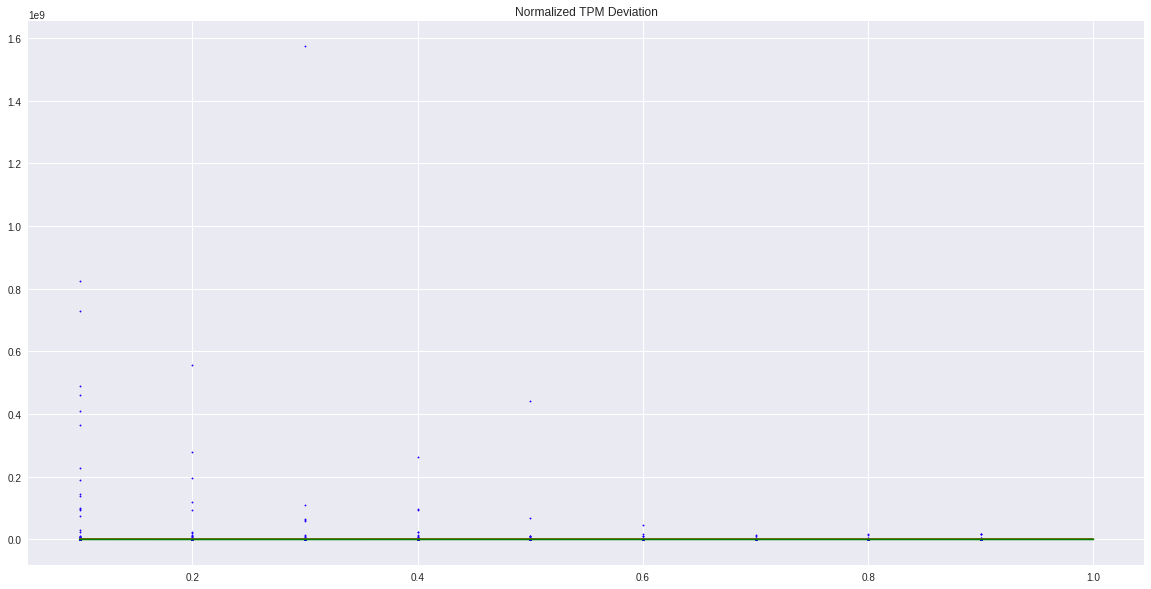

In [16]:
plt.close('all')
plt.figure(figsize=(20,10))
# plt.yscale('log',basey=2)
plt.title('Normalized TPM Deviation')
plt.plot(dataSF["sf"], dataSF["median"],'k',color='#CC4F1B')
for xe, ye in zip(dataSF["sf"], dataSF["extremes"]):
    plt.scatter([xe]*len(ye), ye, color='#1e00ff',s=2,vmin=0.1)
    
plt.fill_between(dataSF["sf"], dataSF["q25"], dataSF["q75"],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.fill_between(dataSF["sf"], dataSF["whiskLow"], dataSF["whiskHigh"],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.plot(dataSF["sf"], dataSF["mean"],'k',color='green')

plt.show()

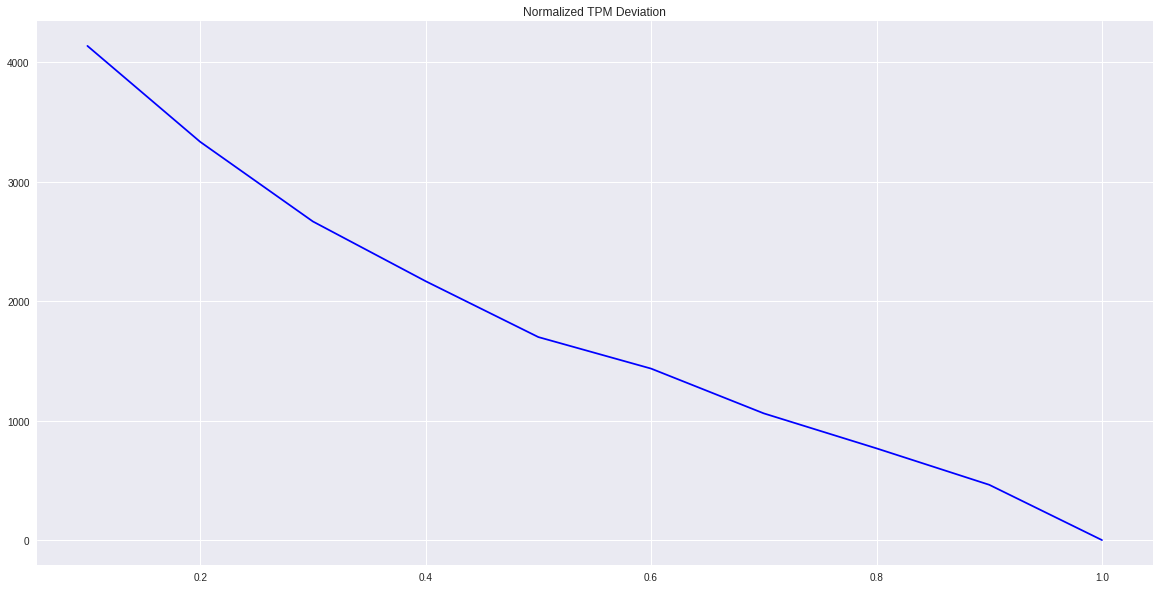

In [17]:
plt.close('all')
plt.figure(figsize=(20,10))
# plt.yscale('log',basey=2)
plt.title('Normalized TPM Deviation')
plt.plot(dataSF["sf"], dataSF["NovelMistakes"],'k',color='blue')
# plt.plot(dataSF["sf"], dataSF["NumLostIndivSamples"],'k',color='black')
# plt.plot(dataSF["sf"], dataSF["NumLostAllSamples"],'k',color='yellow')
# plt.plot(dataSF["sf"], dataSF["NumTranscripts"],'k',color='purple')

plt.show()

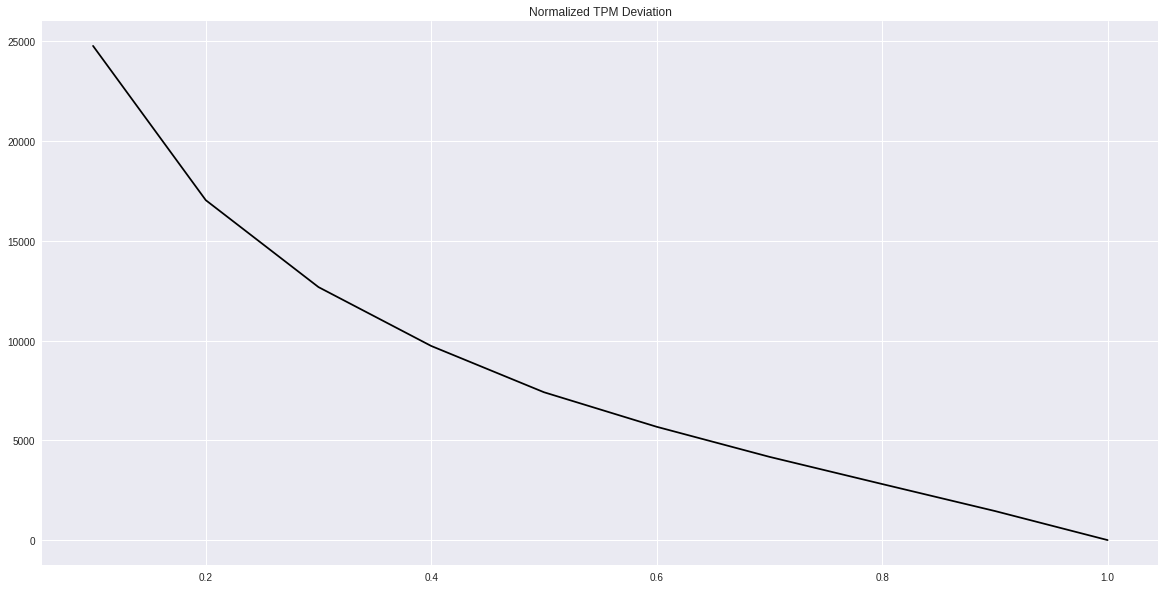

In [18]:
plt.close('all')
plt.figure(figsize=(20,10))
# plt.yscale('log',basey=2)
plt.title('Normalized TPM Deviation')
# plt.plot(dataSF["sf"], dataSF["NovelMistakes"],'k',color='blue')
plt.plot(dataSF["sf"], dataSF["NumLostIndivSamples"],'k',color='black')
# plt.plot(dataSF["sf"], dataSF["NumLostAllSamples"],'k',color='yellow')
# plt.plot(dataSF["sf"], dataSF["NumTranscripts"],'k',color='purple')

plt.show()

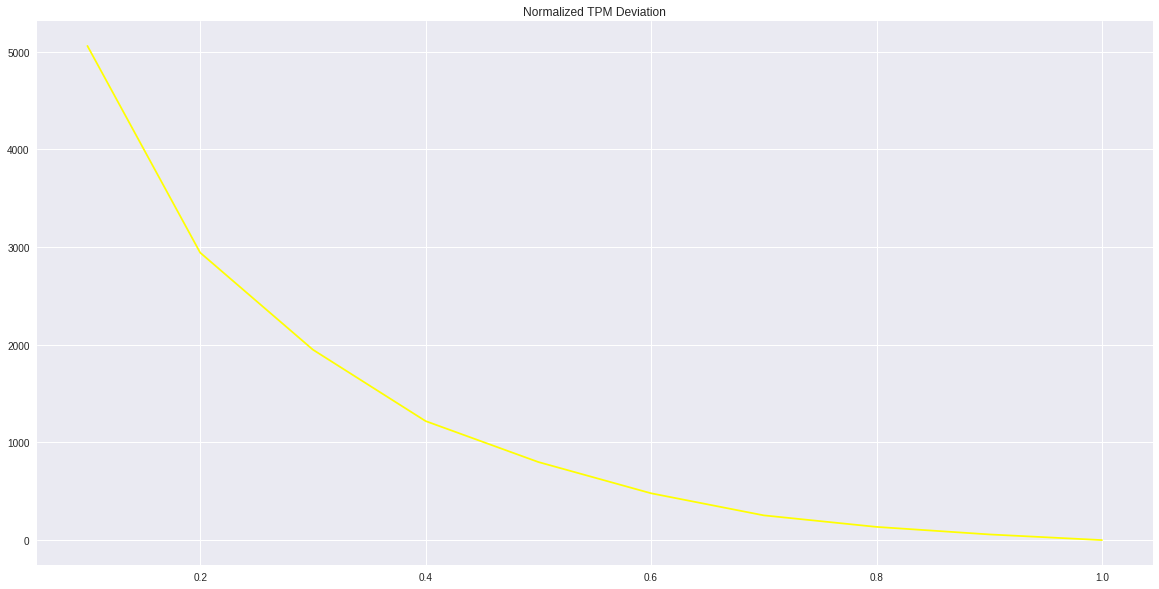

In [19]:
plt.close('all')
plt.figure(figsize=(20,10))
# plt.yscale('log',basey=2)
plt.title('Normalized TPM Deviation')
# plt.plot(dataSF["sf"], dataSF["NovelMistakes"],'k',color='blue')
# plt.plot(dataSF["sf"], dataSF["NumLostIndivSamples"],'k',color='black')
plt.plot(dataSF["sf"], dataSF["NumLostAllSamples"],'k',color='yellow')
# plt.plot(dataSF["sf"], dataSF["NumTranscripts"],'k',color='purple')

plt.show()

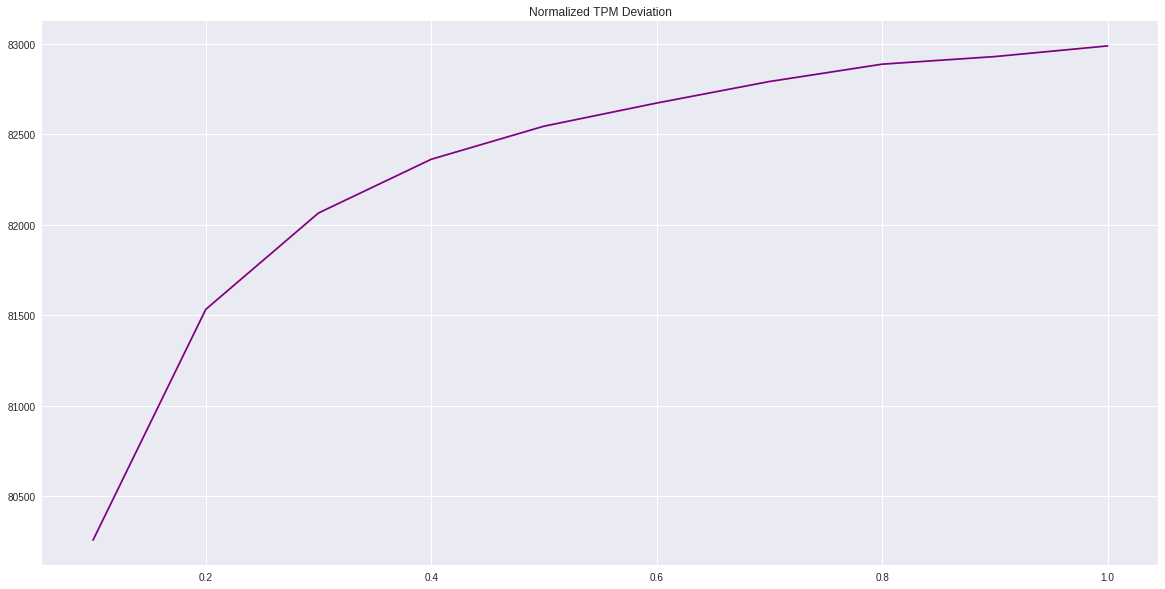

In [20]:
plt.close('all')
plt.figure(figsize=(20,10))
# plt.yscale('log',basey=2)
plt.title('Normalized TPM Deviation')
# plt.plot(dataSF["sf"], dataSF["NovelMistakes"],'k',color='blue')
# plt.plot(dataSF["sf"], dataSF["NumLostIndivSamples"],'k',color='black')
# plt.plot(dataSF["sf"], dataSF["NumLostAllSamples"],'k',color='yellow')
plt.plot(dataSF["sf"], dataSF["NumTranscripts"],'k',color='purple')

plt.show()

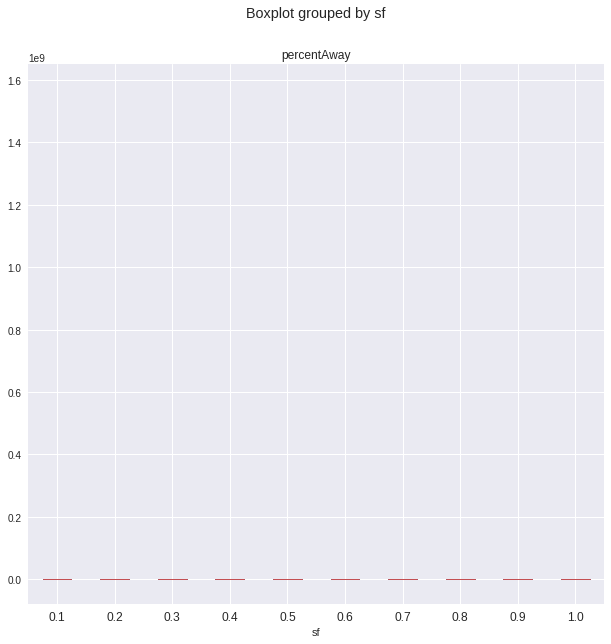

In [21]:
data.boxplot(column="percentAway", by='sf',figsize=(10,10))